# Annotation & inter-annotator agreement analysis

## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from pathlib import Path
import sys
import json

# Add the project root to the Python path to import the modules
project_root = Path().absolute().parent
sys.path.append(str(project_root))

## 1. Create sentence JSON for label-studio annotation

In [ ]:
import spacy

# Load the cleaned referrals dataset
referrals_df = pd.read_csv("../data/processed/brc-cleaned/referrals_cleaned.csv")

# Load spaCy model and add sentencizer
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger"])
if not nlp.has_pipe("sentencizer"):
    nlp.add_pipe("sentencizer")

# Drop rows with missing notes and select relevant columns
referrals_clean = referrals_df.dropna(subset=["Referral Notes (depersonalised)"])[["Case Reference", "Referral Notes (depersonalised)"]]

# Ensure column names are valid Python identifiers
referrals_clean.columns = ["Case_Reference", "Referral_Notes"]

# Sentence splitting
def extract_sentences(row):
    doc = nlp(row.Referral_Notes)
    return [
        {"data": {"text": sent.text.strip()}, "meta": {"case_reference": row.Case_Reference}}
        for sent in doc.sents
        if len(sent.text.strip().split()) >= 3
    ]

# Process all rows
tasks = [task for row in referrals_clean.itertuples(index=False, name="Row") for task in extract_sentences(row)]

# Deduplicate by text
seen = set()
unique_tasks = []
for task in tasks:
    txt = task["data"]["text"]
    if txt not in seen:
        seen.add(txt)
        unique_tasks.append(task)

# Save to JSON
with open("../data/processed/annotations/referral_sentences_for_annotation.json", "w") as f:
    json.dump(unique_tasks, f, indent=2)

/opt/anaconda/envs/keble8263-sdoh-extraction/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## 2. Cross-annotation round 1

### 2.1. Create two lists of sentences to be cross-annotated

In [4]:
import random

INPUT_FILE = "../data/processed/annotations/label-studio/label-studio-annotations-2025-06-26-round1.json"
OUTPUT_CAT = "../data/processed/annotations/round1/BRC_Cat_annotation.csv"
OUTPUT_MAIWENN = "../data/processed/annotations/round1/BRC_Maiwenn_annotation.csv"
SAMPLE_SIZE = 200
SEED = 42

# Load exported data
with open(INPUT_FILE, "r") as f:
    tasks = json.load(f)

# Helper: check if task is only No SDoH
def is_only_no_sdoh(annotations):
    for ann in annotations:
        for r in ann.get("result", []):
            if r.get("from_name") != "no_sdoh" or "True" not in r.get("value", {}).get("choices", []):
                return False
    return True

# Filter and sample
sdoh_sentences = [
    task["data"]["text"].strip()
    for task in tasks
    if not is_only_no_sdoh(task.get("annotations", []))
]

random.seed(SEED)
sampled = random.sample(sdoh_sentences, min(SAMPLE_SIZE, len(sdoh_sentences)))

# Split and save
mid = len(sampled) // 2
pd.DataFrame(sampled[:mid], columns=["Sentence"]).to_csv(OUTPUT_CAT, index=False)
pd.DataFrame(sampled[mid:], columns=["Sentence"]).to_csv(OUTPUT_MAIWENN, index=False)

print(f"✅ Created '{OUTPUT_CAT}' and '{OUTPUT_MAIWENN}' with {mid} sentences each.")

✅ Created '../data/processed/annotations/round1/BRC_Cat_annotation.csv' and '../data/processed/annotations/round1/BRC_Maiwenn_annotation.csv' with 71 sentences each.


### 2.2. Compare my annotations to BRC staff annotations

In [5]:
from src.annotation.parse_annotations_helpers import parse_labelstudio_json, parse_csv_annotations

round1_labelstudio_path = "../data/processed/annotations/label-studio/label-studio-annotations-2025-06-26-round1.json"
round1_BRC_Cat_annotation_path = "../data/processed/annotations/round1/BRC_Cat_annotation_completed.csv"

# Parse my Label Studio JSON annotations for round 1
parsed_annotations_round1_df = parse_labelstudio_json(round1_labelstudio_path)

# Parse BRC staff annotations for round 1
parsed_CAT_annotations_round1_df = parse_csv_annotations(round1_BRC_Cat_annotation_path, "BRC_Cat")

# Get list of cross-annotated sentences (those Cat labeled)
cross_sentences = parsed_CAT_annotations_round1_df["Sentence"].unique()

# Filter both DataFrames to just those sentences
parsed_annotations_round1_filtered_df = parsed_annotations_round1_df[parsed_annotations_round1_df["Sentence"].isin(cross_sentences)].copy()

In [6]:
from src.annotation.cross_annotation_helpers import compare_annotations_krippendorff, compute_classwise_krippendorff

# Get mismatches
alpha, mismatches = compare_annotations_krippendorff(parsed_annotations_round1_filtered_df, parsed_CAT_annotations_round1_df)

# Save mismatches to CSV
mismatches.to_csv("../data/processed/annotations/round1/mismatches.csv", index=False)

# Compute classwise Krippendorff's alpha
alpha_df = compute_classwise_krippendorff(
    parsed_annotations_round1_filtered_df,
    parsed_CAT_annotations_round1_df,
    save_latex=True,
    latex_path="../results/latex_tables/classwise_krippendorff_round1.tex"
)

## 3. Final annotation EDA

In [9]:
from src.annotation.parse_annotations_helpers import parse_labelstudio_json

# Most recent annotation file path
annotation_path = "../data/processed/annotations/label-studio/label-studio-annotations-2025-06-29-17-28-05ccd4c1.json"

# Load the most recent annotations
annotations_df = parse_labelstudio_json(annotation_path)

"No SDoH" proportion: 53.7% (481 out of 895 annotations)
Number of sentences with at least one valid SDoH: 327


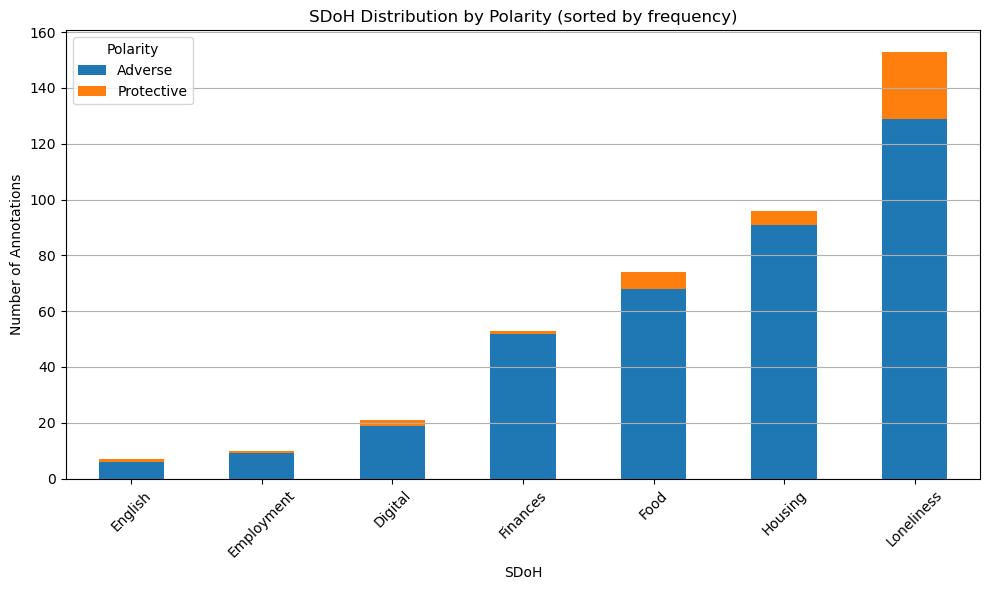

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each SDoH (regardless of polarity)
sdoh_counts = annotations_df["SDoH"].value_counts()

# Compute proportion of "No SDoH"
no_sdoh_count = sdoh_counts.get("No SDoH", 0)
no_sdoh_prop = no_sdoh_count / len(annotations_df) * 100
print(f'"No SDoH" proportion: {no_sdoh_prop:.1f}% ({no_sdoh_count} out of {len(annotations_df)} annotations)')

# Number of distinct sentences with at least one valid SDoH
valid_sdoh_sentences = annotations_df[annotations_df["SDoH"] != "No SDoH"]["Sentence"].nunique()
print(f"Number of sentences with at least one valid SDoH: {valid_sdoh_sentences}")

# Group and sort by total count
sdoh_polarity_counts = annotations_df.groupby(["SDoH", "Polarity"]).size().unstack(fill_value=0)
sdoh_polarity_counts["total"] = sdoh_polarity_counts.sum(axis=1)
sdoh_polarity_counts_sorted = sdoh_polarity_counts.sort_values("total").drop(columns="total")

# Plot
sdoh_polarity_counts_sorted.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("SDoH Distribution by Polarity (sorted by frequency)")
plt.xlabel("SDoH")
plt.ylabel("Number of Annotations")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()